In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
from custom_xgb.custom_xgb import CustomXGBoost
from utils import evaluate, remove_outliners

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeltaYStopper, DeadlineStopper

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

In [3]:
# Total: ~ 10mins
np.random.seed(0)

# Data Handling

## Loading data

In [4]:
train_df = pd.read_csv(TRAIN_PATH)

cat_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
num_cols = train_df.columns.difference(cat_cols + ['loan_status'])

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32999 entries, 0 to 32998
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32999 non-null  float64
 1   person_gender                   32999 non-null  object 
 2   person_education                32999 non-null  object 
 3   person_income                   32999 non-null  float64
 4   person_emp_exp                  32999 non-null  int64  
 5   person_home_ownership           32999 non-null  object 
 6   loan_amnt                       32999 non-null  float64
 7   loan_intent                     32999 non-null  object 
 8   loan_int_rate                   32999 non-null  float64
 9   loan_percent_income             32999 non-null  float64
 10  cb_person_cred_hist_length      32999 non-null  float64
 11  credit_score                    32999 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
train_df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,32999.000000,3.299900e+04,32999.000000,32999.000000,32999.000000,32999.000000,32999.000000,32999.000000,32999.000000
mean,27.738568,8.038576e+04,5.516470,9587.230310,11.001461,0.139147,5.811358,633.003697,0.215400
std,6.333872,7.425788e+04,6.333516,6317.895438,3.069164,0.086783,4.050483,50.379861,0.411106
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,23.000000,4.748550e+04,1.000000,5000.000000,8.490000,0.070000,3.000000,602.000000,0.000000
50%,26.000000,6.718800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.654300e+04,8.000000,12100.000000,13.110000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [7]:
train_df.sample(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
11609,23.0,male,High School,84847.0,0,RENT,10000.0,MEDICAL,9.99,0.12,4.0,642,No,0
7564,26.0,male,Associate,46166.0,2,RENT,6400.0,PERSONAL,9.88,0.14,2.0,618,No,0
25399,30.0,female,Bachelor,46479.0,10,OWN,6000.0,EDUCATION,11.58,0.13,7.0,617,Yes,0
13503,22.0,male,High School,112571.0,0,MORTGAGE,9250.0,VENTURE,7.90,0.08,3.0,664,Yes,0
13939,26.0,male,Associate,119086.0,1,MORTGAGE,8450.0,VENTURE,6.99,0.07,2.0,623,Yes,0


## Distribution Annalysis

### Checking Label Distribution

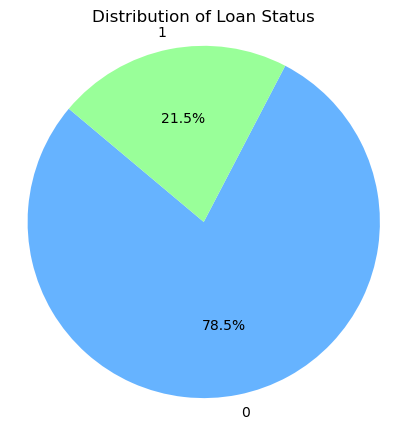

In [8]:
# Count the occurrences of each loan status
loan_status_counts = train_df['loan_status'].value_counts()

# Plot the pie chart
plt.figure(figsize=(5, 5))
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99'])
plt.title('Distribution of Loan Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Checking Numerical Features Distribution

Some numerical columns such as `person_age`, `person_emp_exp`, `person_income`, `loan_int_rate` contain some outliners.

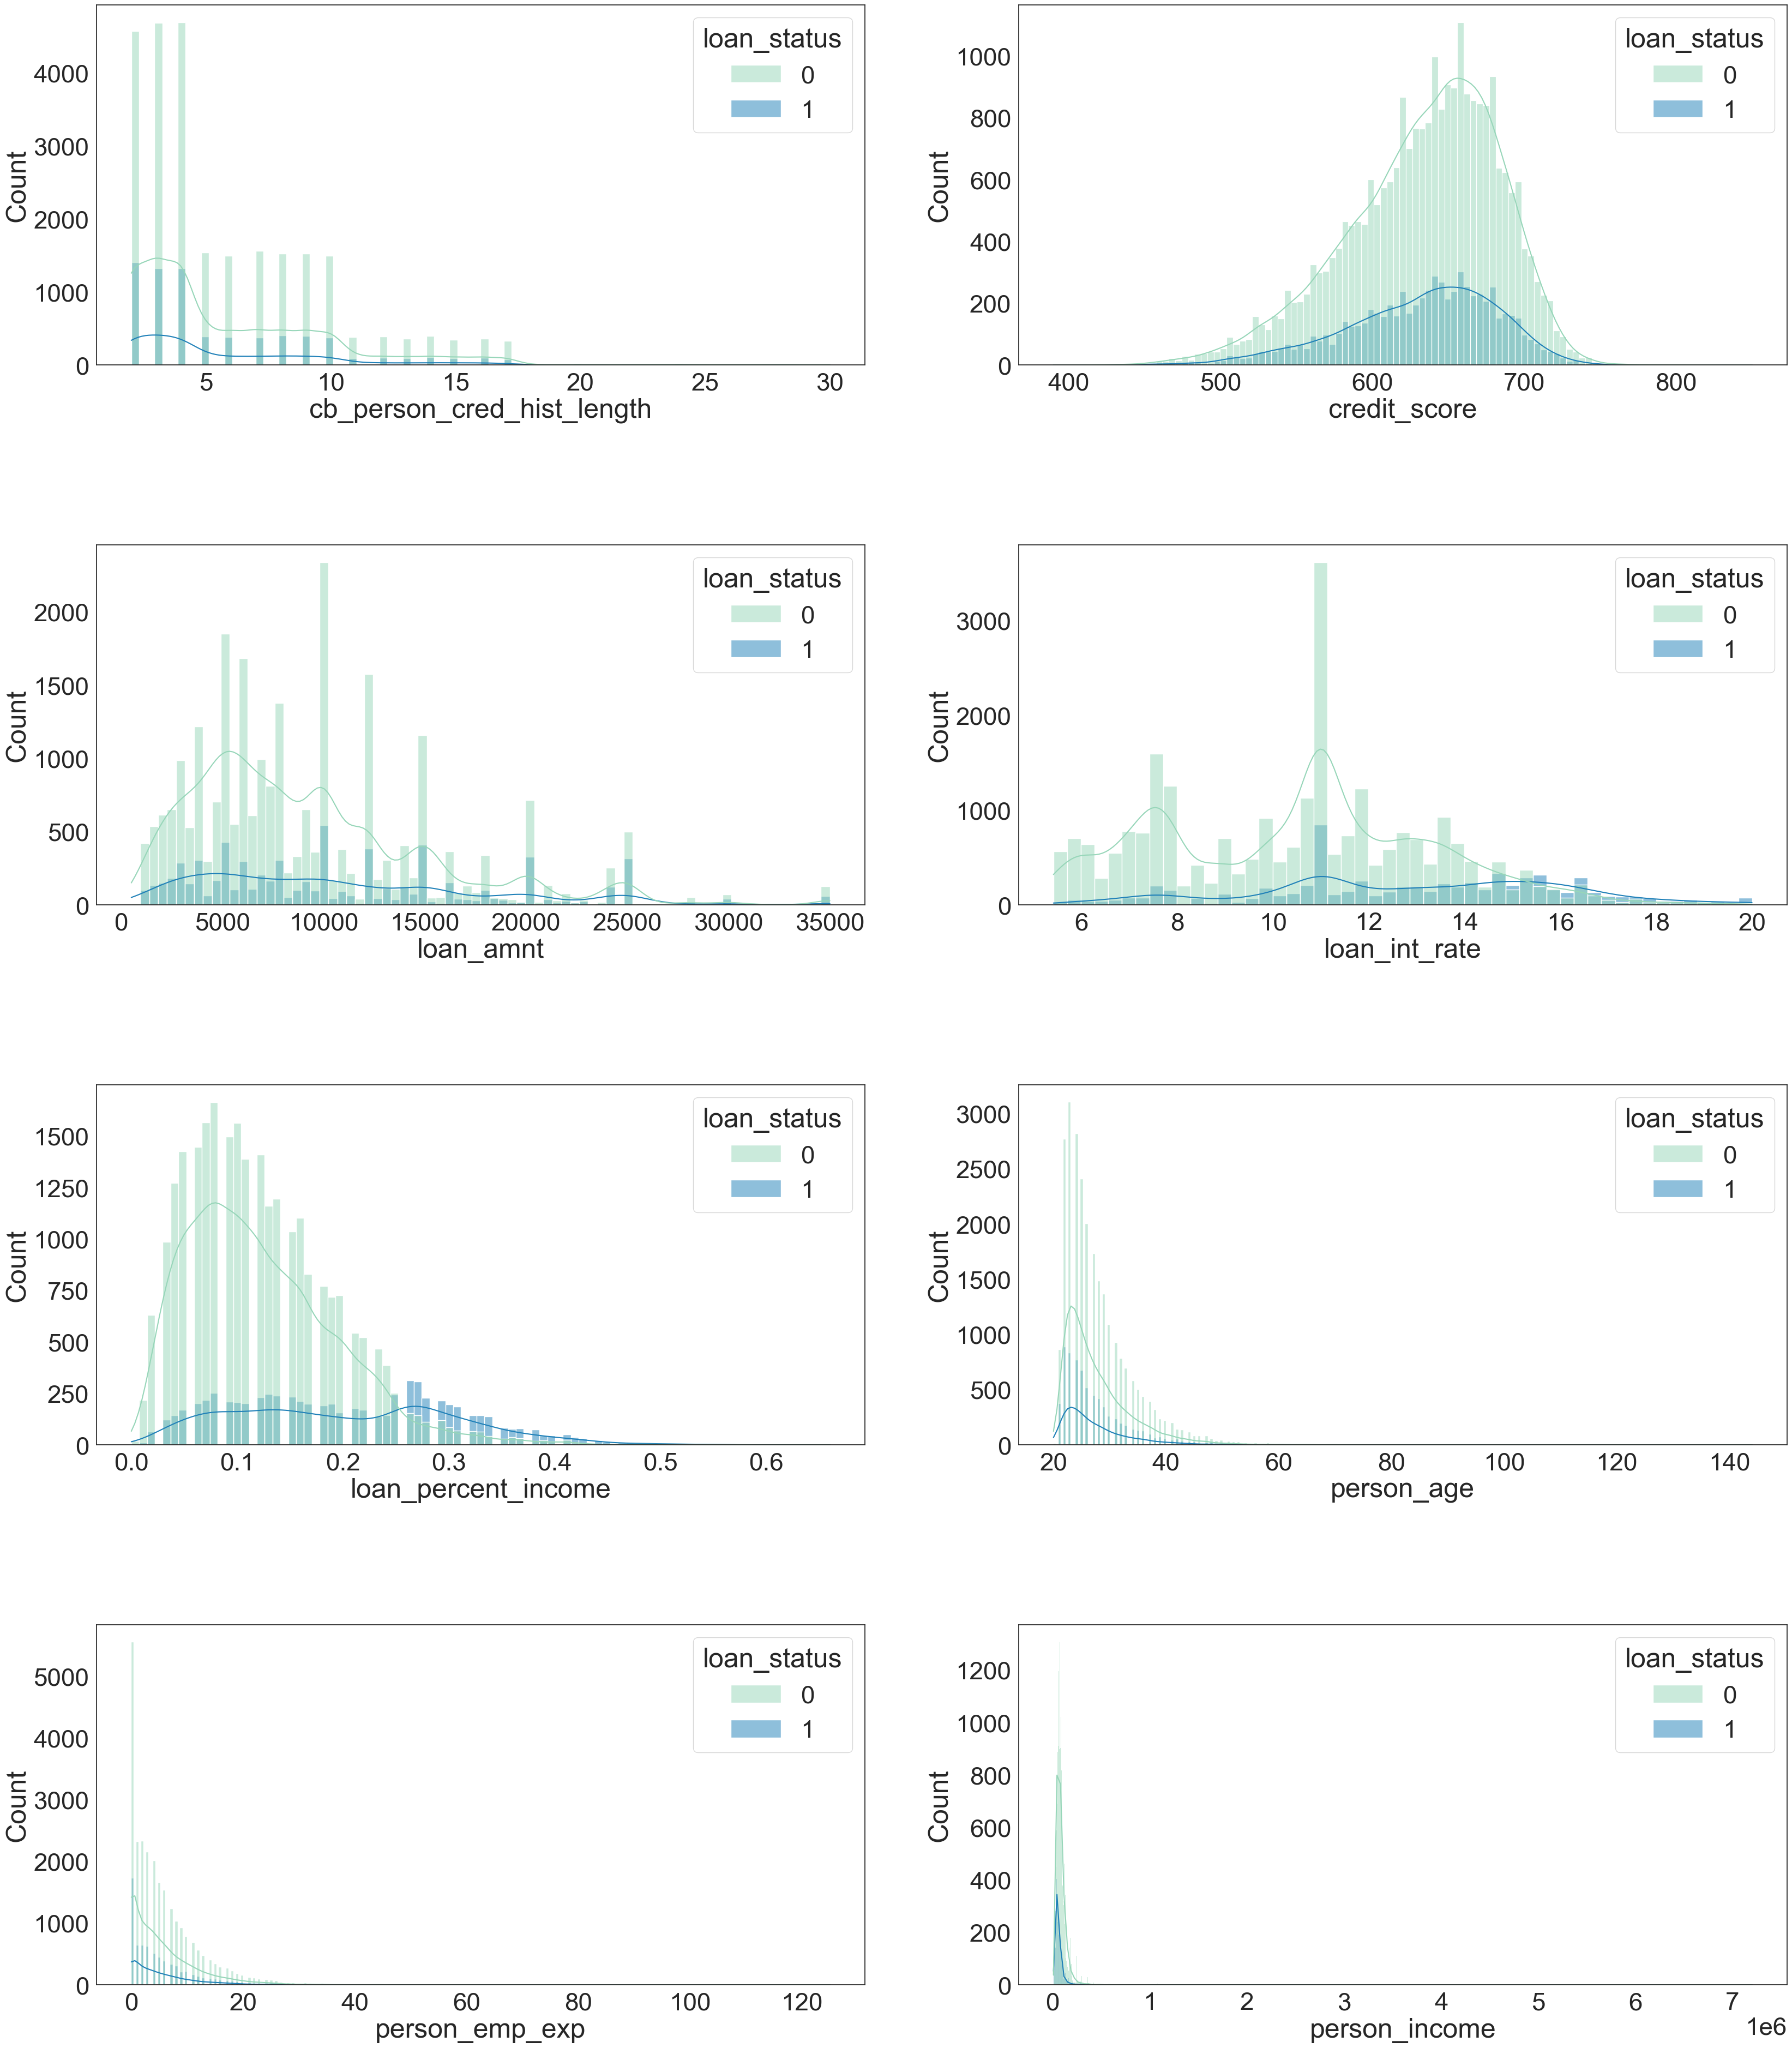

In [9]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
for name in num_cols:
    plt.subplot(5,2,i)
    sns.histplot(data=train_df, x=name, hue="loan_status",kde=True,palette="YlGnBu")
    i = i + 1

### Checking Categorical Features Distribution

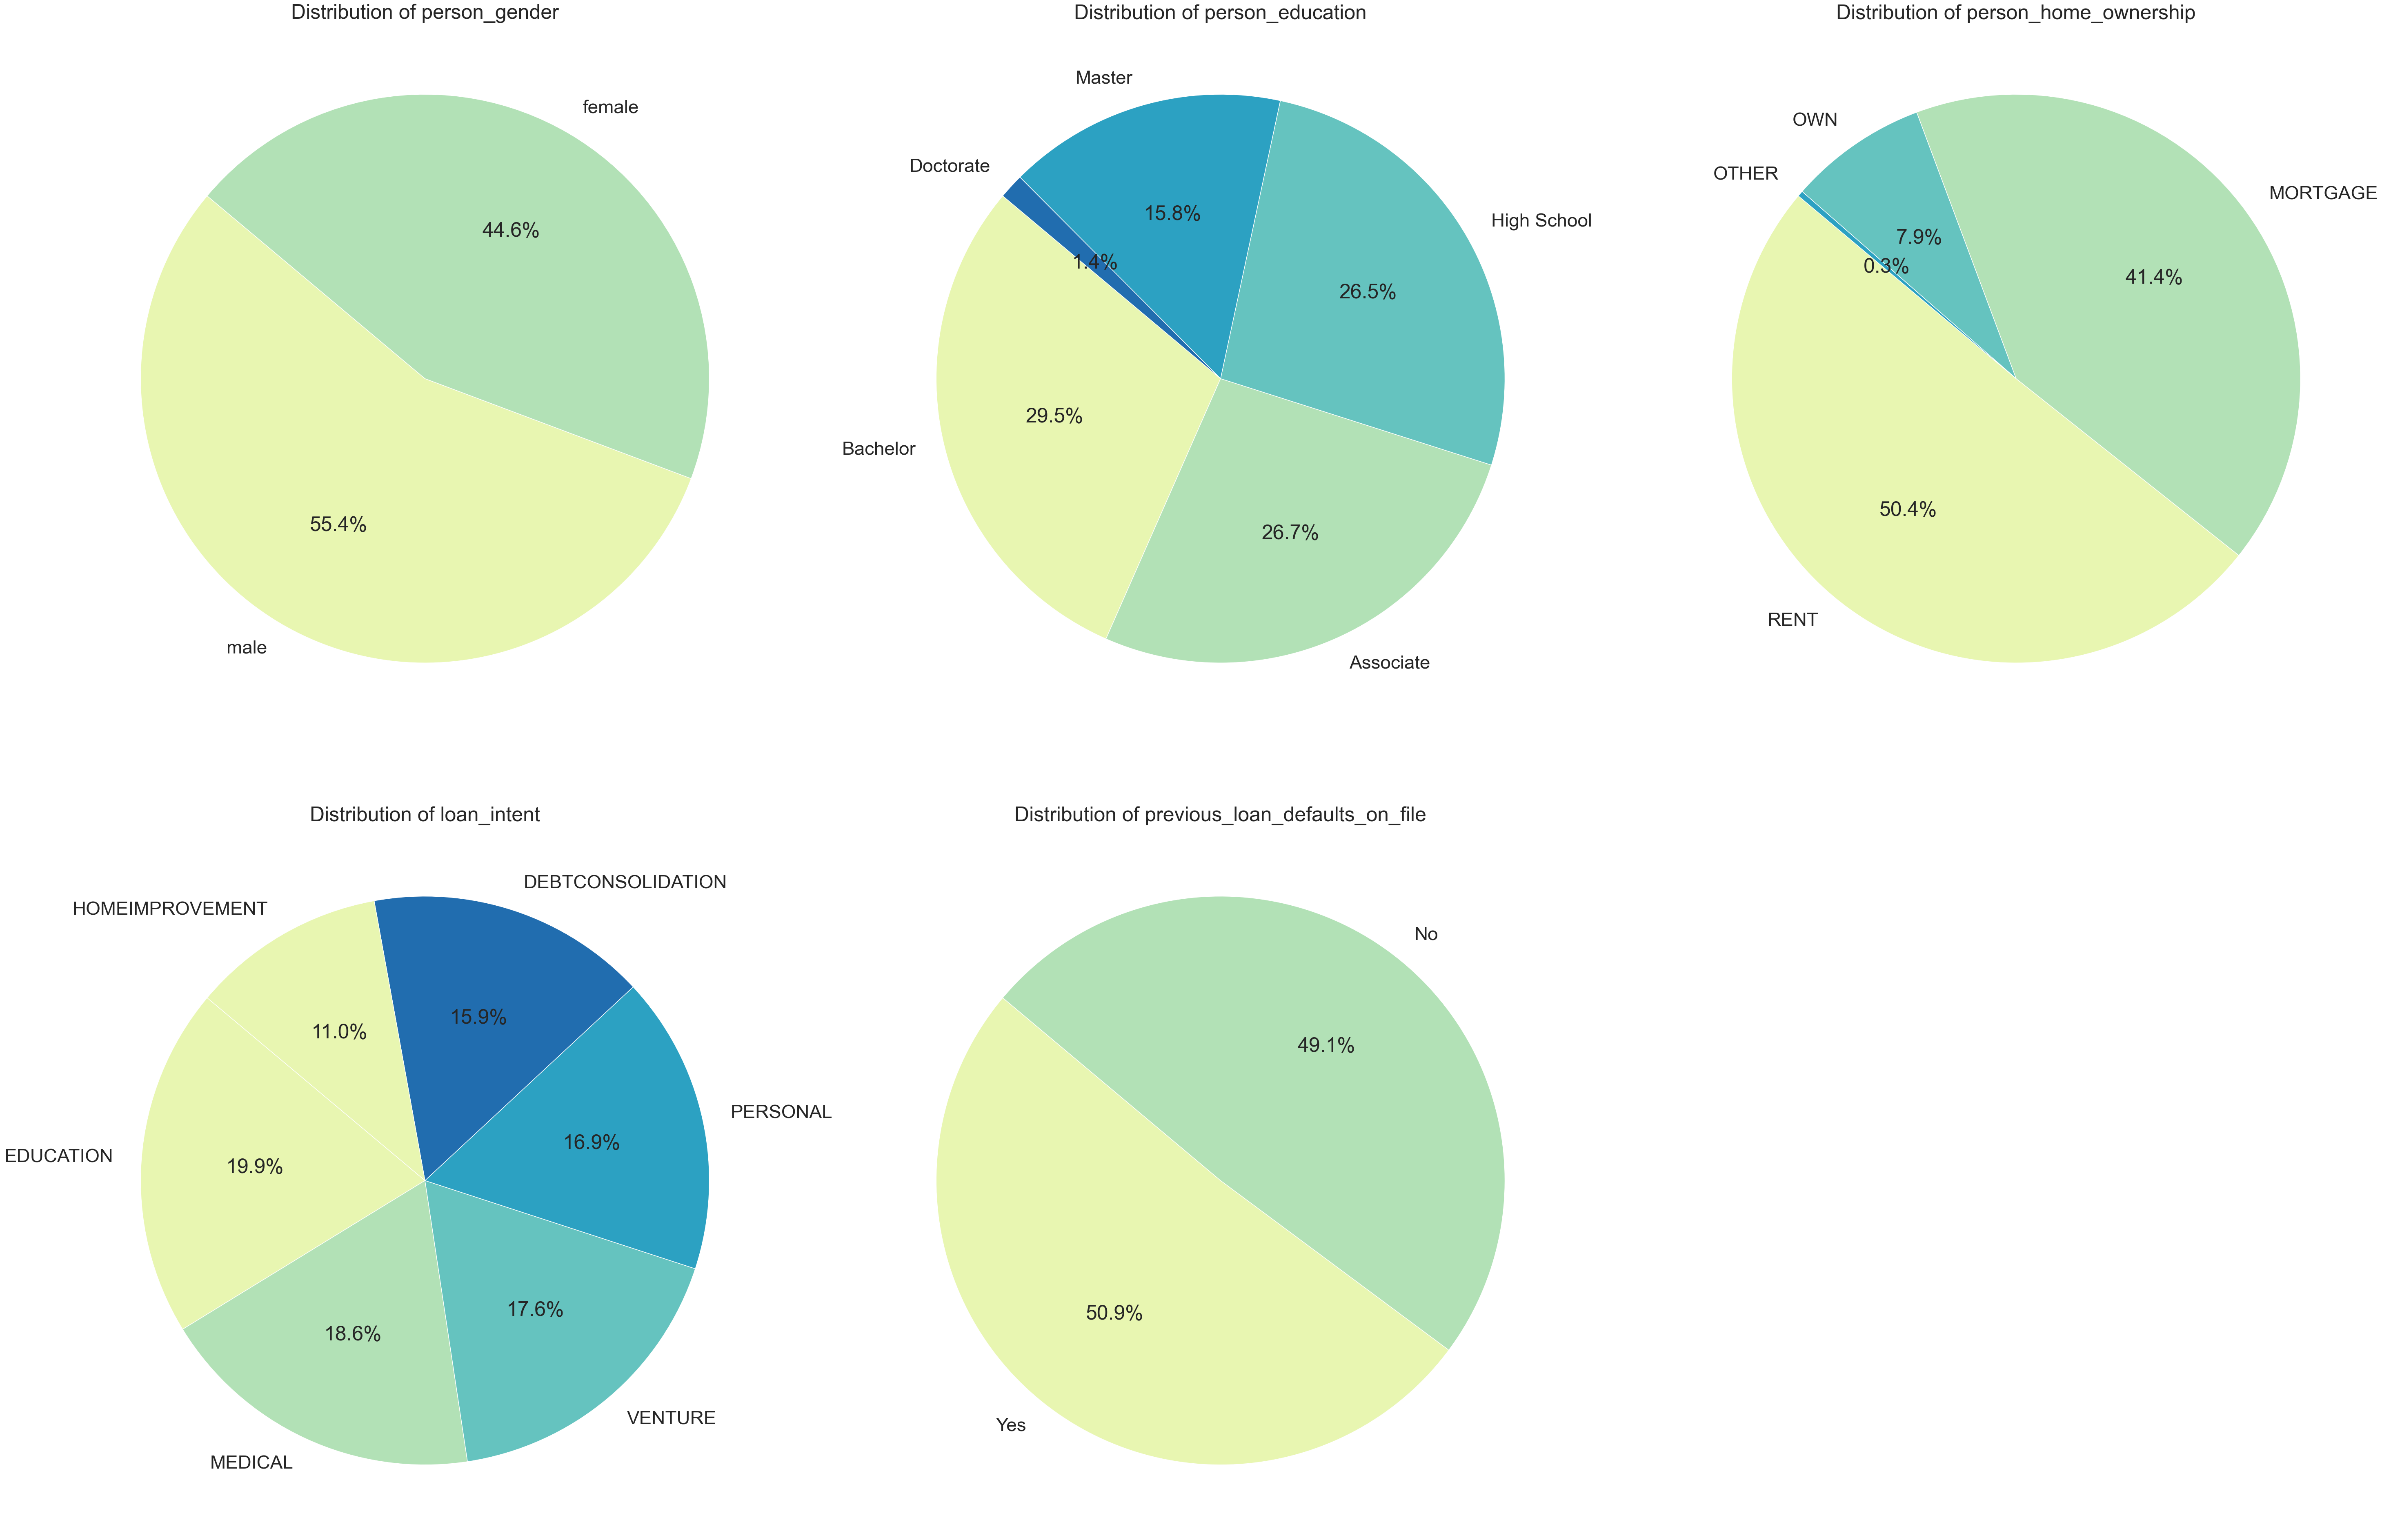

In [10]:
colors = sns.color_palette('YlGnBu')[0:5]
i = 1
plt.figure(figsize=(60, 40))
for name in cat_cols:
    plt.subplot(2, 3, i)
    train_df[name].value_counts().plot.pie(autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Distribution of {name}')
    plt.ylabel('')
    i += 1
plt.tight_layout()
plt.show()

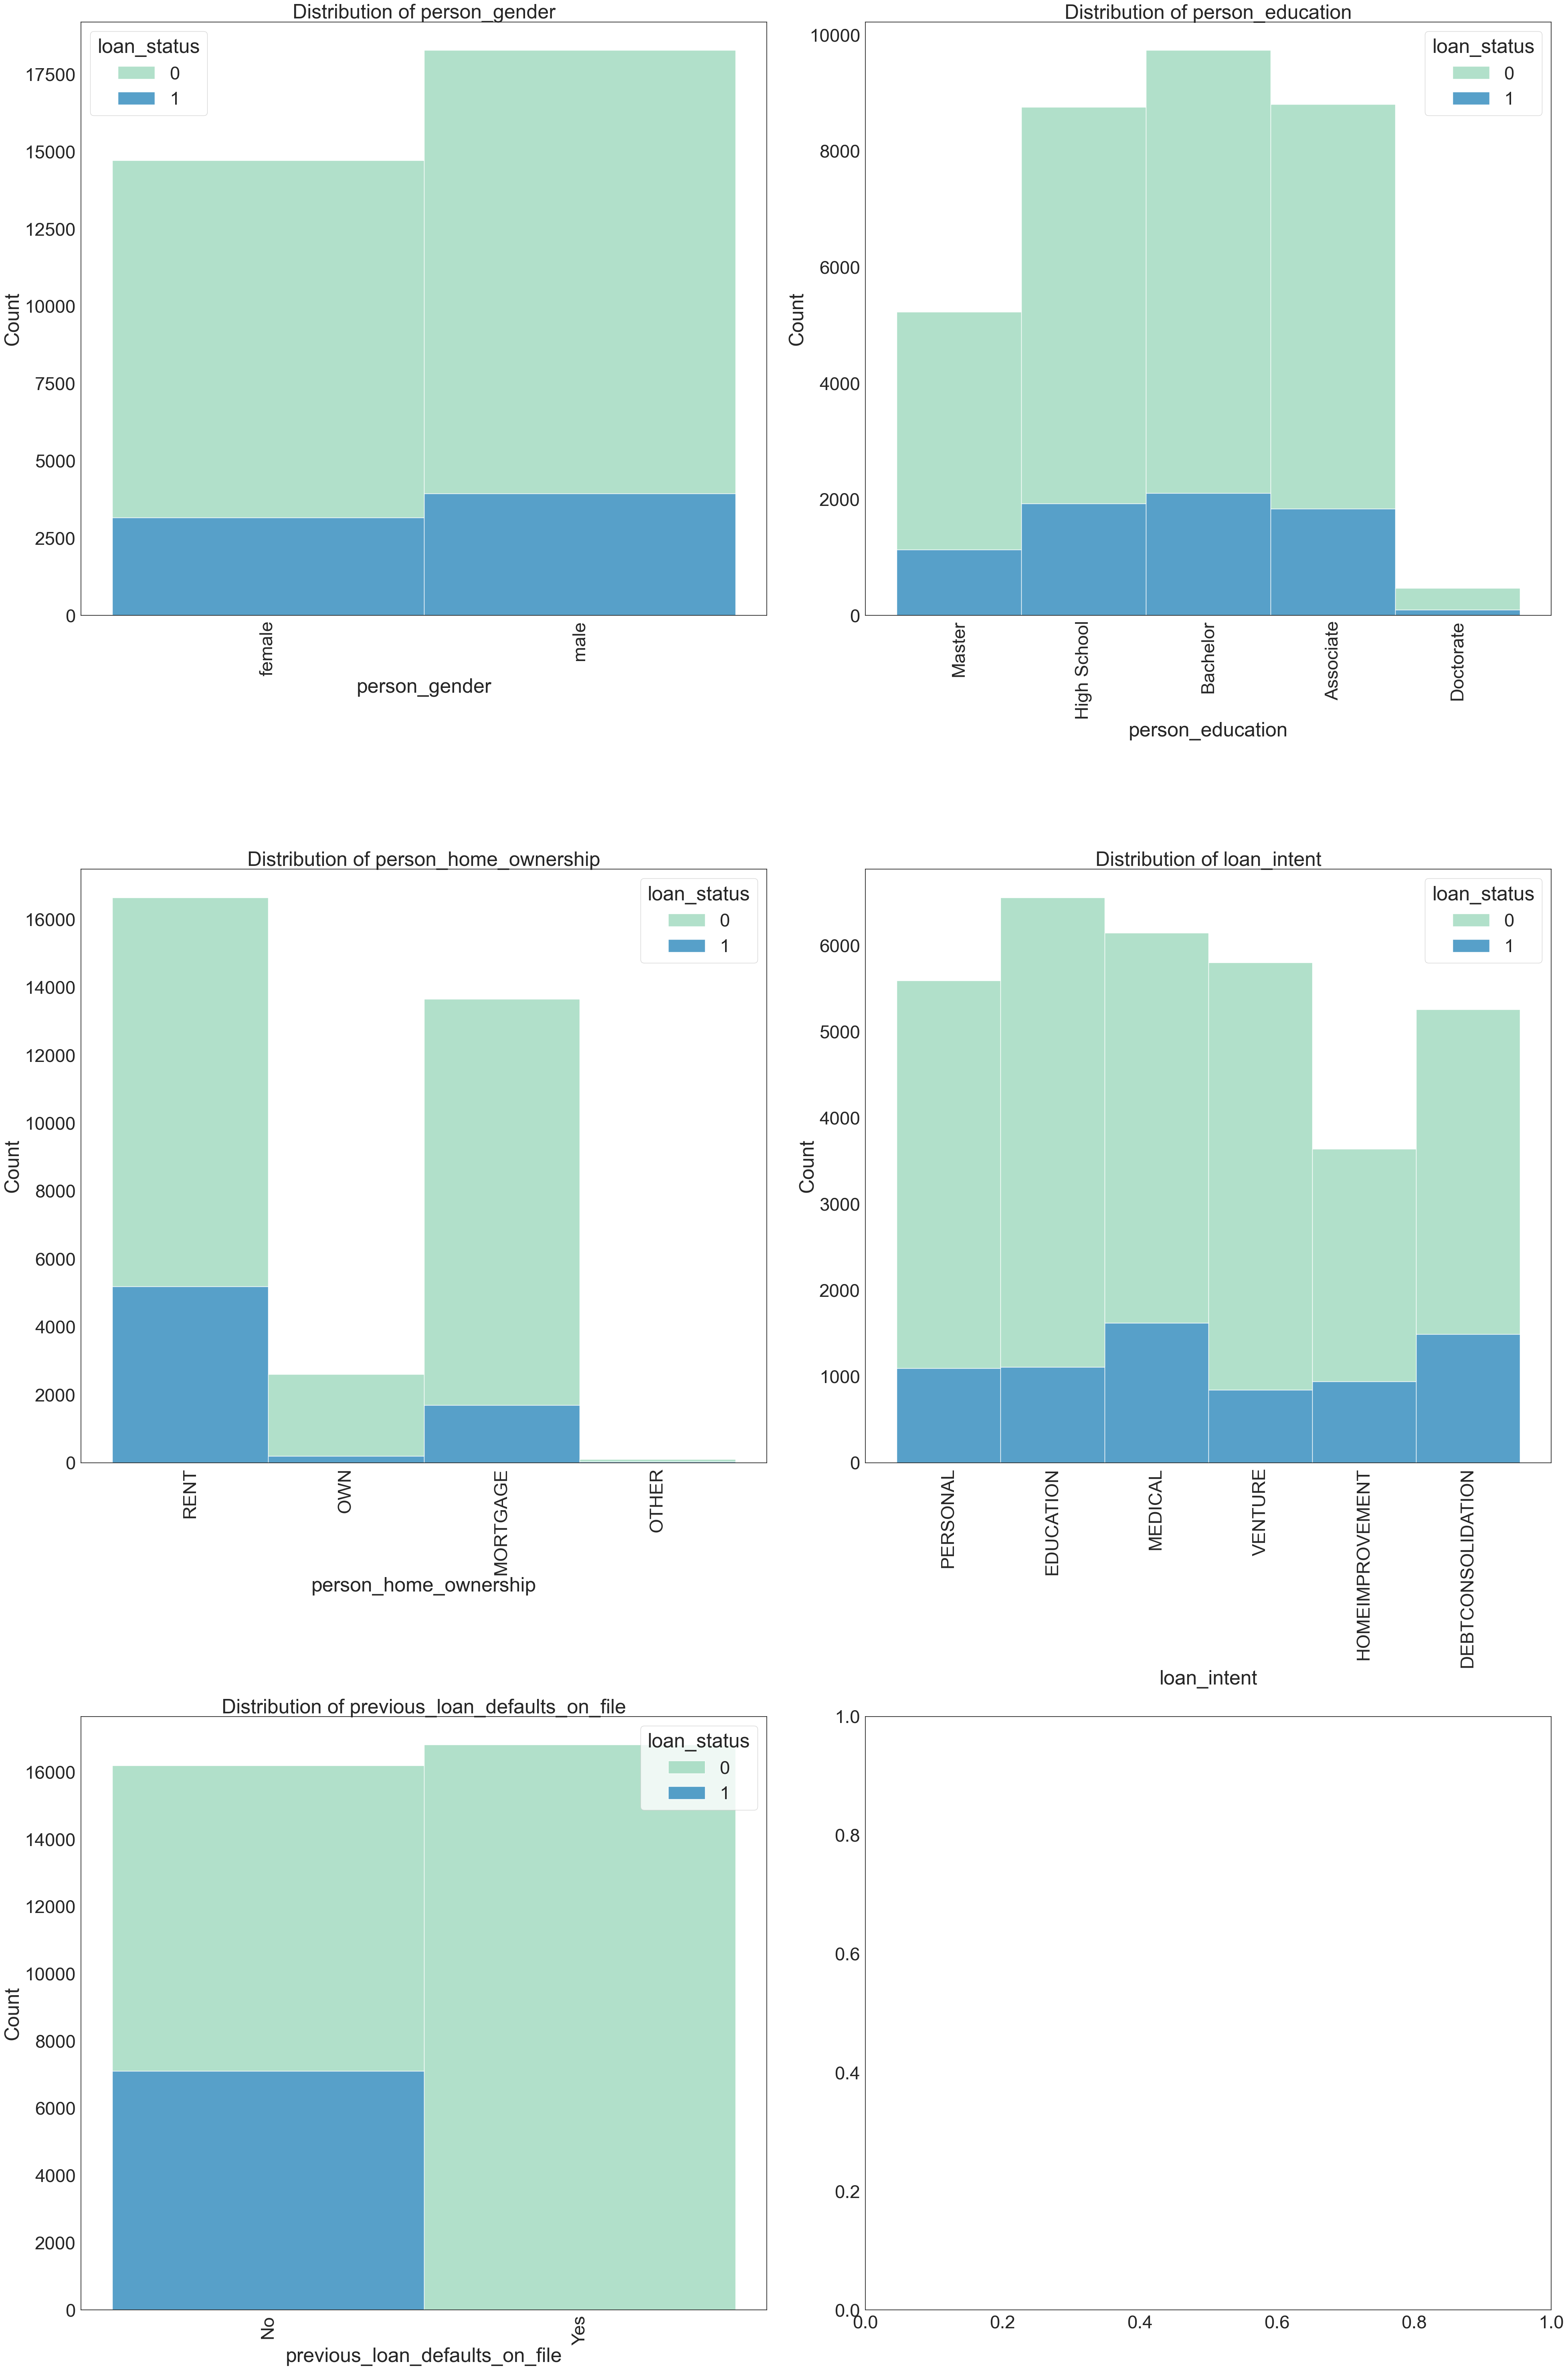

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(40, 60))
axes = axes.flatten()

try:
    for i, feature in enumerate(cat_cols):
        sns.histplot(data=train_df, x=feature, hue="loan_status", multiple="stack", palette="YlGnBu", ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].tick_params(axis='x', rotation=90)
except:
    pass
plt.tight_layout()
plt.show()

### Principal Component Analysis

As the explained variance ratios aren't too skewed, we can keep all the features

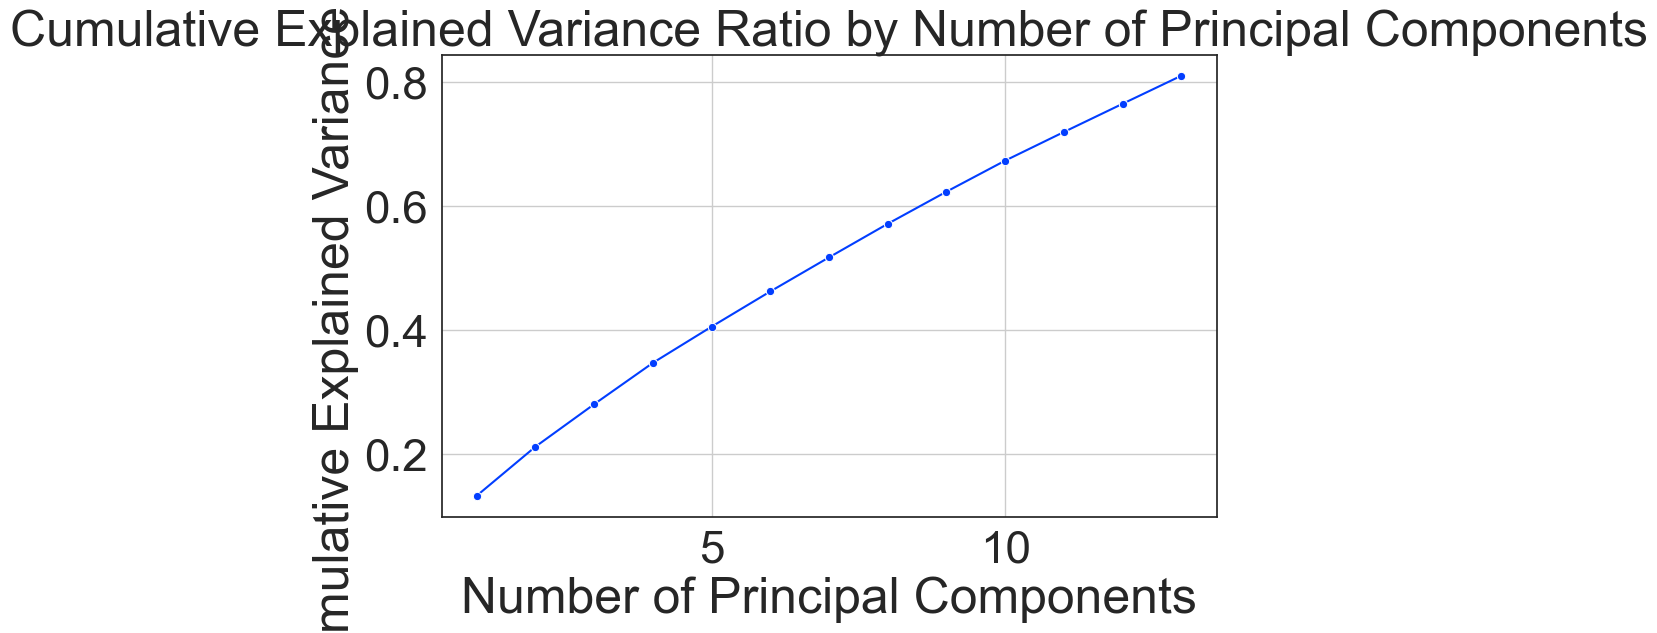

In [ ]:
pca_transformer = Pipeline([
    ('ohe',ColumnTransformer(
        [('cat_trans', OneHotEncoder(drop='first'), cat_cols)], 
        remainder='passthrough'
    )),
    ('scaler',StandardScaler()),
])

X_pca = pd.DataFrame(train_df.iloc[:,:-1])
X_pca_transformed = pca_transformer.fit_transform(pd.DataFrame(train_df.iloc[:,:-1]))
pca = PCA(n_components=len(X_pca.columns))
pca.fit(X_pca_transformed)
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Create a DataFrame for cumulative explained variance ratio
cvr = pd.DataFrame({
    'Number of Principal Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Explained Variance Ratio': cumulative_variance
})

# Set up the figure
plt.figure(figsize=(15, 10))

sns.set_theme(font_scale = 3)
# Create the line plot using Seaborn
sns.lineplot(data=cvr, 
             x='Number of Principal Components', 
             y='Cumulative Explained Variance Ratio', 
             marker='o')  # Adding markers for clarity

# Add title and labels
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability
plt.grid(True)

# Show the figure
plt.show()

## Data Preprocessing

### Removing Outliers

In [13]:
features_to_remove_outliners = num_cols

train_data_trunc = remove_outliners(train_df, features_to_remove_outliners)

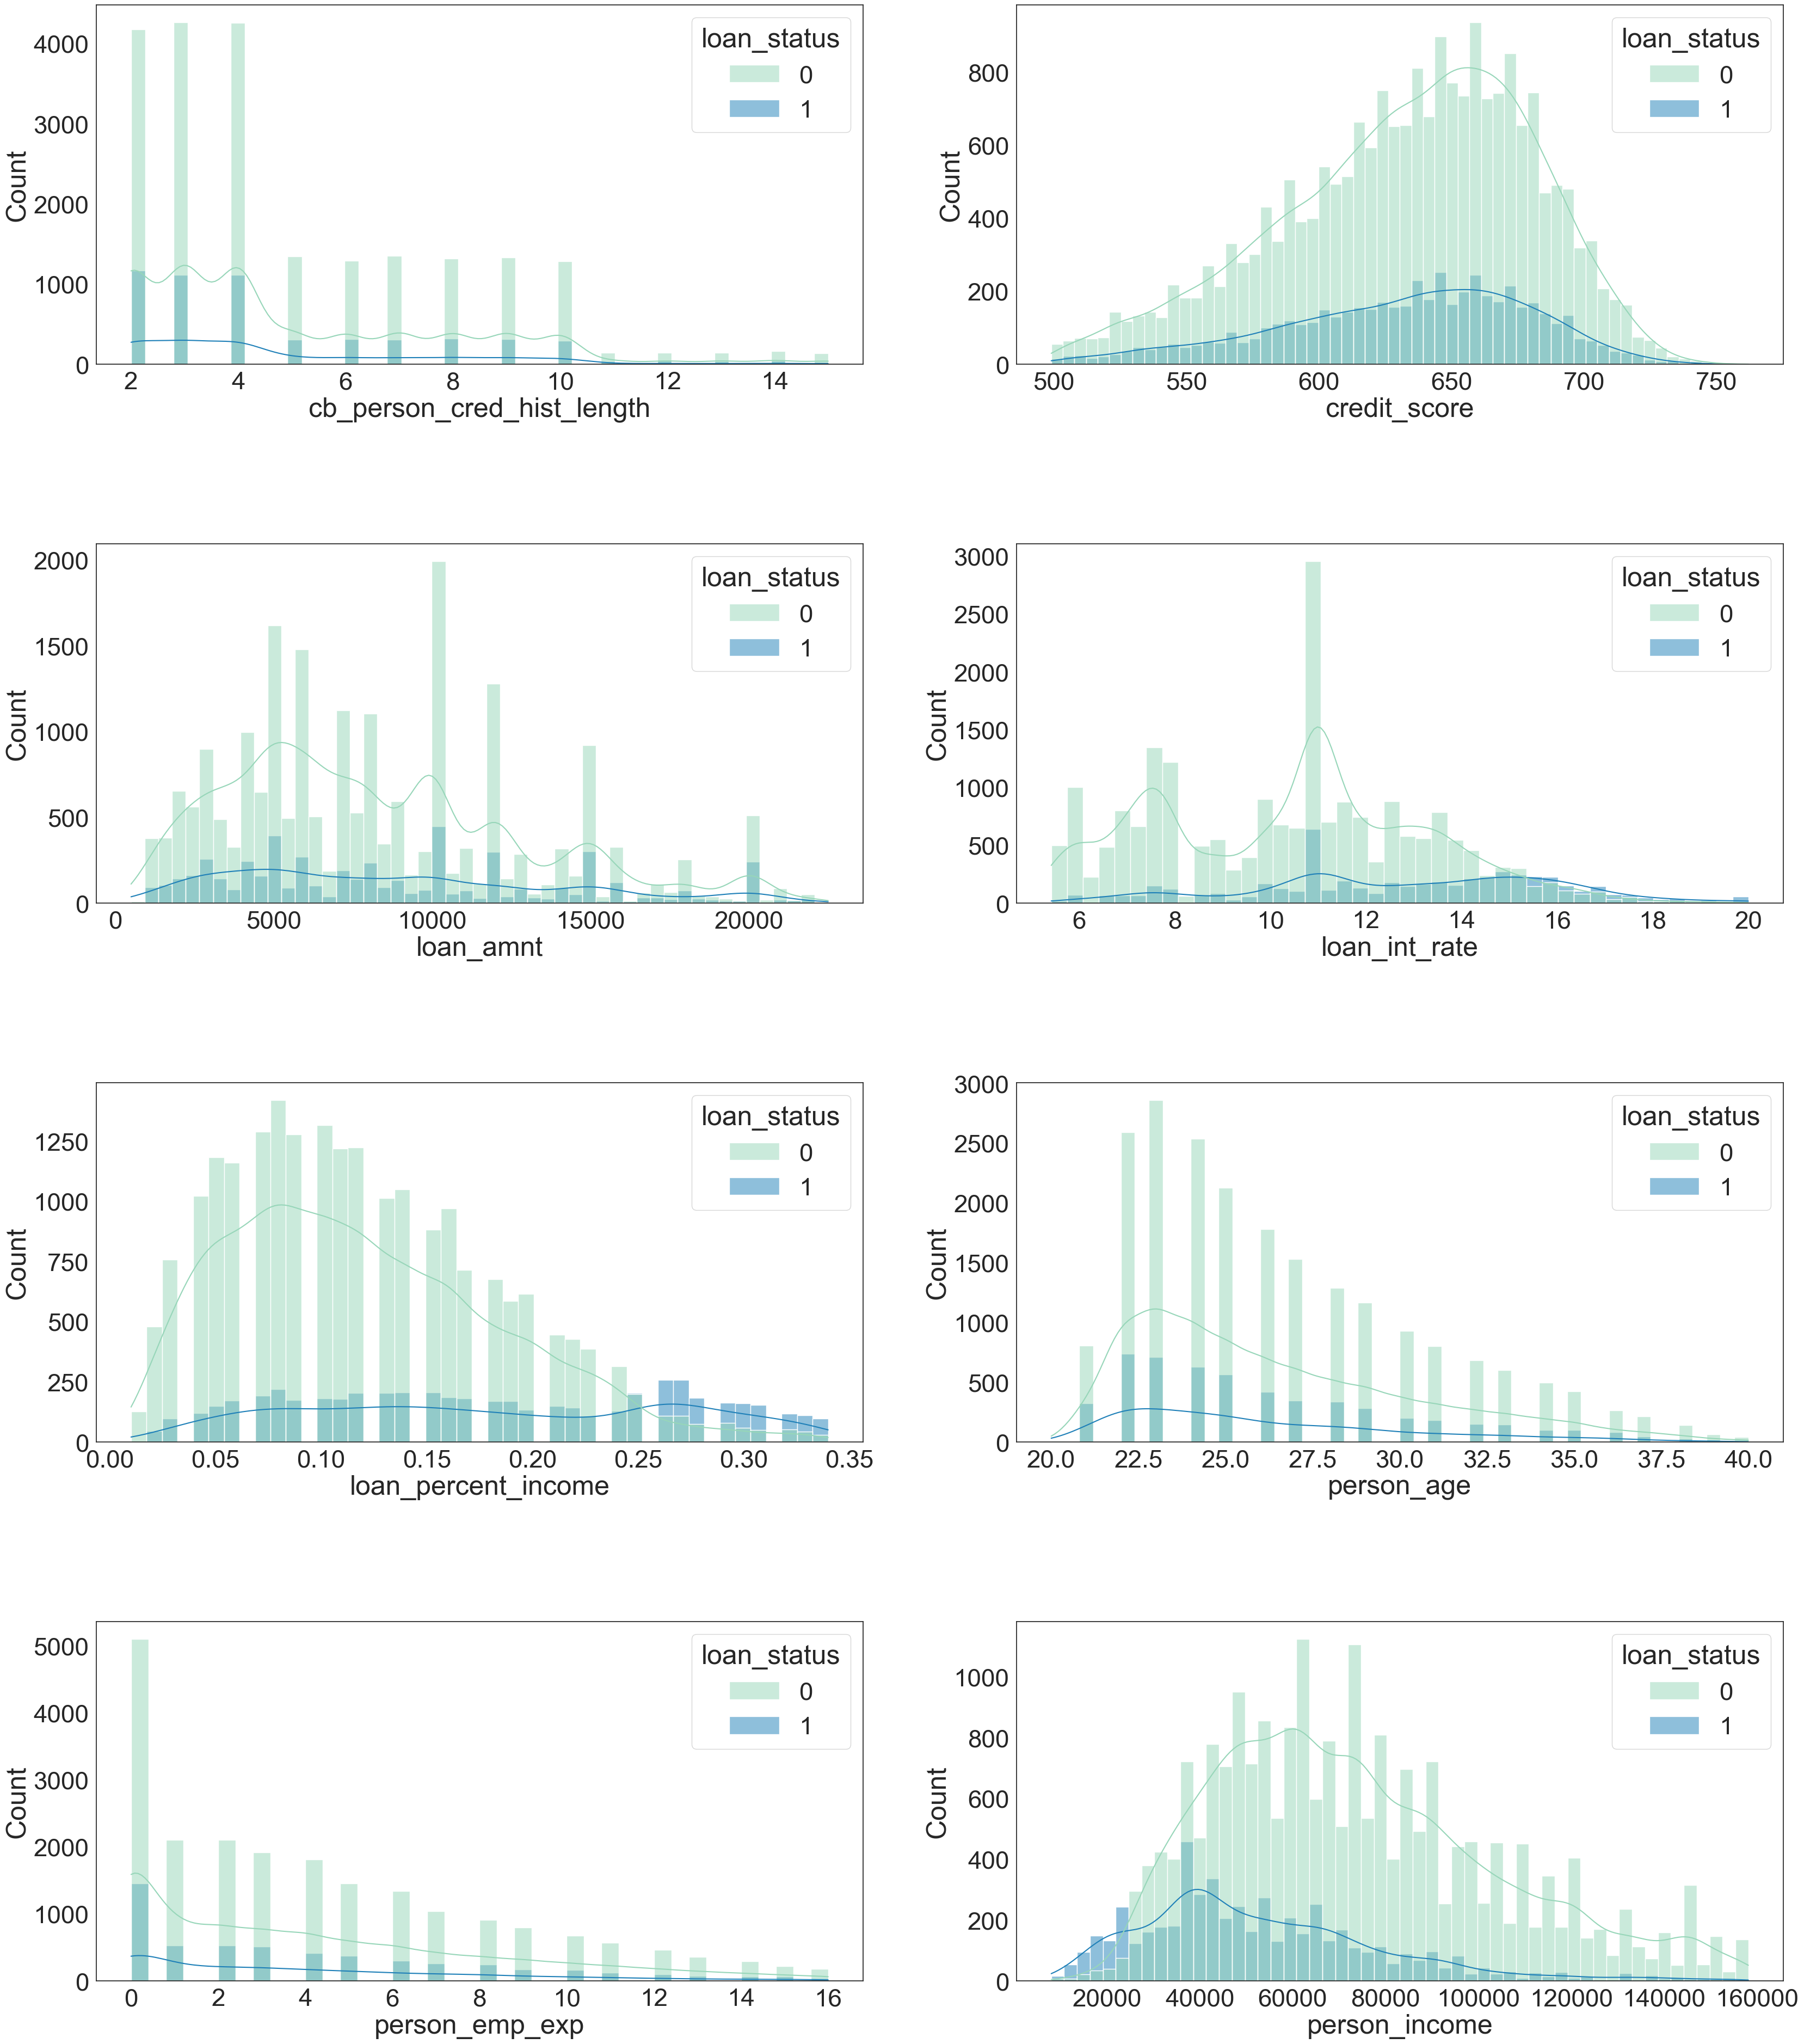

In [14]:

# Replot to see the new distribution

rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1
try:
    for name in num_cols:
            plt.subplot(5,2,i)
            sns.histplot(data=train_data_trunc, x=name, hue="loan_status",kde=True,palette="YlGnBu")
            i = i + 1
except:
    pass

### Split data

In [15]:
X_train, y_train = train_df.iloc[:,:-1], train_df.iloc[:,-1]

### Data Encoding

In this project, we use one hot encoding exclusively and drop the first column of each categorical feature (including booleans).

In [16]:
transformer = Pipeline([
    ('ohe',ColumnTransformer(
        [('cat_trans', OneHotEncoder(drop='first'), cat_cols)], 
        remainder='passthrough'
    )),
    # ('scaler',StandardScaler()),
])

transformer.fit(X_train)
X_train = transformer.transform(X_train)

### Resampling

As we've seen above, the labels are skewed towards 0 (Negative). Therefore, we apply SMOTE and TomekLinks as resampling techniques to help mitigate this problem.

In [17]:
print("The number of samples in the training set is: ", X_train.shape[0])
print("Class 0: ", y_train.value_counts()[0]*100/X_train.shape[0], "%")
print("Class 1: ", y_train.value_counts()[1]*100/X_train.shape[0], "%")

The number of samples in the training set is:  32999
Class 0:  78.45995333191915 %
Class 1:  21.54004666808085 %


In [18]:
# Over-sampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("The number of samples after SMOTE in the training set is: ", X_train.shape[0])
print("Class 0: ", y_train.value_counts()[0]*100/X_train.shape[0], "%")
print("Class 1: ", y_train.value_counts()[1]*100/X_train.shape[0], "%")

The number of samples after SMOTE in the training set is:  51782
Class 0:  50.0 %
Class 1:  50.0 %


In [19]:
# Cleaning Under-sampling
# Apply Tomek Links to clean the data
tomek = TomekLinks()
X_train, y_train = tomek.fit_resample(X_train, y_train)

print("The number of samples after applying Tomek Links is: ", X_train.shape[0])
print("Class 0: ", y_train.value_counts()[0]*100/X_train.shape[0], "%")
print("Class 1: ", y_train.value_counts()[1]*100/X_train.shape[0], "%")

The number of samples after applying Tomek Links is:  49807
Class 0:  51.98265304073725 %
Class 1:  48.01734695926275 %


# Training & Hyper-parameter Tuning

## Individual Models

### Custom XGBoost

In [20]:
custom_xgb = CustomXGBoost(lr=0.3, n_estimators = 50, max_depth=6, row_subsample_ratio=0.6, reg_lambda=1.0)
print(custom_xgb.predict_proba(X_train))
custom_xgb.fit(X_train, y_train)
# ~ 2mins

[[0.5 0.5]]


CustomXGBoost(lr=0.3, max_depth=6, n_estimators=50, reg_lambda=1.0,
              row_subsample_ratio=0.6)

### XGBoost (Library)

In [21]:
params = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 15),
    'learning_rate': Real(0.05, 0.2, prior='log-uniform'),
    'subsample': Real(0.4, 0.7),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(3, 5),
    'scale_pos_weight': Real(1, 10)
}

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=5)

# Create the BayesSearchCV object
std_xgb = BayesSearchCV(
    estimator=XGBClassifier(eval_metric='aucpr', random_state=42), 
    search_spaces=params, 
    n_iter=100, 
    cv=kf, 
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=42,
    optimizer_kwargs={'base_estimator': 'GP'}
    )

# Fit the BayesSearchCV object to the data
std_xgb.fit(X_train, y_train, callback=[DeltaYStopper(0.001), DeadlineStopper(60*45)])


print('Best parameters:', std_xgb.best_params_)
print('Best score:', std_xgb.best_score_)
# ~ 2ms

Best parameters: OrderedDict({'colsample_bytree': 0.6003807338179179, 'gamma': 0.06211333455476033, 'learning_rate': 0.10991953718269483, 'max_depth': 8, 'n_estimators': 487, 'reg_alpha': 0.7440200201666554, 'reg_lambda': 4.659026414579122, 'scale_pos_weight': 6.539561389892449, 'subsample': 0.653239610883847})
Best score: 0.9862842169653898


### LightGBM

In [22]:
params = {
    'learning_rate': [0.1],
    'n_estimators': [200],
    'reg_lambda': [0, 0.1, 1],
    'row_subsample_ratio': [0.5, 0.8, 1.0],
    'num_leaves': [20,31],
}
kf = StratifiedKFold(n_splits=5)
lgbm = GridSearchCV(
    LGBMClassifier(**params, verbosity=-1),
    param_grid=params, 
    cv=kf, 
    scoring='roc_auc',
    n_jobs=2,
    ).fit(X_train, y_train)
print('Best parameters:', lgbm.best_params_)
print('Best score:', lgbm.best_score_)
# ~ 1m10s

Best parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 20, 'reg_lambda': 1, 'row_subsample_ratio': 0.5}
Best score: 0.9776691561172006


### CatBoost

In [23]:
params = {
    'l2_leaf_reg': Real(1, 5),
    'bagging_temperature': Real(0, 0.5),
    'scale_pos_weight': Real(1, 5)
}

# Create a StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Configure the BayesSearchCV
catb = BayesSearchCV(
    estimator=CatBoostClassifier(
        iterations=100,
        verbose=0,
        random_state=42,
        border_count=254,
        learning_rate=0.3,
        depth=6,
        allow_writing_files=False),
    search_spaces=params,
    scoring='roc_auc',
    n_iter=50,  # Number of parameter settings that are sampled
    cv=cv,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42
)

# Fit the BayesSearchCV to the data
catb.fit(X_train, y_train, callback=[DeltaYStopper(0.001), DeadlineStopper(60*45)])

print('Best parameters:', catb.best_params_)
print('Best score:', catb.best_score_)
# ~ 1min

Best parameters: OrderedDict({'bagging_temperature': 0.3670140089927842, 'l2_leaf_reg': 4.7574789504110875, 'scale_pos_weight': 1.654428714554201})
Best score: 0.9840353538654234


### Deprecated

AdaBoost, RandomForest, LogisticRegression

In [24]:
# params = {
#     'learning_rate': [0.5, 1, 1.5],
#     'n_estimators': [100],
# }
# kf = StratifiedKFold(n_splits=3)
# ada = GridSearchCV(
#     ensemble.AdaBoostClassifier(algorithm='SAMME'),
#     param_grid=params,
#     cv=kf, 
#     scoring='accuracy',
#     n_jobs=2,
#     ).fit(X_train, y_train)
# print('Best parameters:', ada.best_params_)
# print('Best score:', ada.best_score_)
# ~ 30s

In [25]:
# rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy')
# rf = rf.fit(X_train, y_train)

In [26]:
# log_reg = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], scoring='roc_auc', max_iter=500)
# log_reg = log_reg.fit(X_train, y_train)

## Training Meta Classifiers

### Stacking Ensemble

In [27]:
stacking_ensemble = ensemble.StackingClassifier([
    ('std_xgb', std_xgb),
    ('custom_xgb', custom_xgb),
    ('lgbm', lgbm),
    ('catb', catb),
    # ('rf', rf),
    # ('ada', ada),
    # ('logreg', log_reg),
], cv='prefit')

stacking_ensemble.fit(X_train, y_train)

StackingClassifier(cv='prefit',
                   estimators=[('std_xgb',
                                BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                              estimator=XGBClassifier(base_score=None,
                                                                      booster=None,
                                                                      callbacks=None,
                                                                      colsample_bylevel=None,
                                                                      colsample_bynode=None,
                                                                      colsample_bytree=None,
                                                                      device=None,
                                                                      early_stopping_rounds=None,
                                                                      enable_categorical=False,
                                                                      eval_metric='aucpr',...
                                              estimator=<catboost.core.CatBoostClassifier object at 0x000001BFAEBFAAE0>,
                                              n_jobs=-1,
                                              optimizer_kwargs={'base_estimator': 'GP'},
                                              random_state=42,
                                              scoring='roc_auc',
                                              search_spaces={'bagging_temperature': Real(low=0, high=0.5, prior='uniform', transform='normalize'),
                                                             'l2_leaf_reg': Real(low=1, high=5, prior='uniform', transform='normalize'),
                                                             'scale_pos_weight': Real(low=1, high=5, prior='uniform', transform='normalize')}))])

# Evaluations

## Choosing the optimal decision threshold

0.8110000000000003


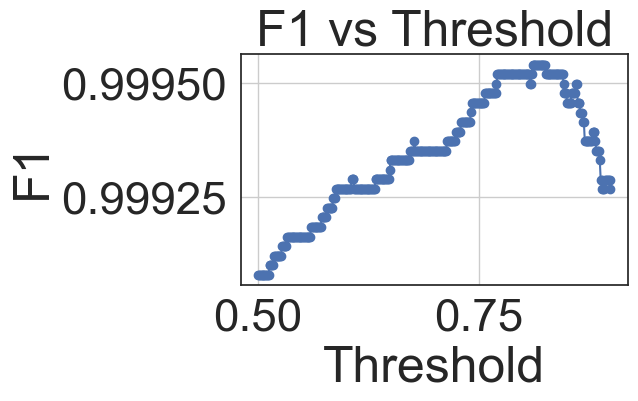

In [28]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on the test set
y_test_proba = stacking_ensemble.predict_proba(X_train)[:, 1]

# Define the range of thresholds
thresholds = np.arange(0.5, 0.9, 0.001)

# Calculate accuracy for each threshold
accuracies = []
max = 0
for threshold in thresholds:
    y_test_pred = (y_test_proba >= threshold).astype(int)
    f1 = f1_score(y_train, y_test_pred)
    accuracies.append(f1)
    if f1 > max:
        max = f1
        optimal_threshold = threshold

print(optimal_threshold)
# Plot the f1 against the thresholds
plt.figure(figsize=(5, 3))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()
# 2m

In [31]:
# from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
# from sklearn.model_selection import cross_val_score

# y_scores = cross_val_score(stacking_ensemble, X_train, y_train, cv=5,
#                              scoring='roc_auc', n_jobs=-1)

# precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:, -1])
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
# plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
# plt.xlabel('Threshold')
# plt.ylabel('Precision/Recall')
# plt.title('Precision and Recall vs Threshold')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()

In [32]:
# # Compute ROC curve and ROC area
# fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, -1])
# roc_auc = roc_auc_score(y_train, y_scores[:, -1])

# print(f"ROC AUC Score: {roc_auc}")

# # Plot ROC curve
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# Results

In [33]:
test_df = pd.read_csv(TEST_PATH)

X_test, y_test = transformer.transform(test_df.iloc[:,:-1]), test_df.iloc[:,-1]

## Individual Models

### Custom XGBoost

In [34]:
print('Train metrics:')
evaluate(custom_xgb, X_train, y_train, threshold=optimal_threshold)
print('\n')
print('Test metrics:')
evaluate(custom_xgb, X_test, y_test, threshold=optimal_threshold)
1

Train metrics:
Accuracy: 0.9238862007348365
F1: 0.9144378992032862
Precision: 0.99347751458977
Recall: 0.8470480013380164


Test metrics:
Accuracy: 0.905
F1: 0.7595951075495572
Precision: 0.9735135135135136
Recall: 0.6227524204702628


1

### XGBoost (From Library)

In [35]:
print('Train metrics:')
evaluate(std_xgb, X_train, y_train, threshold=optimal_threshold)
print('\n')
print('Test metrics:')
evaluate(std_xgb, X_test, y_test, threshold=optimal_threshold)
1

Train metrics:
Accuracy: 0.9996386050153593
F1: 0.9996236986244095
Precision: 0.999581904841542
Recall: 0.9996654959023248


Test metrics:
Accuracy: 0.93575
F1: 0.85719577699574
Precision: 0.9230155564419625
Recall: 0.8001383125864454


1

### LightGBM

In [36]:
print('Train metrics:')
evaluate(lgbm, X_train, y_train, threshold=optimal_threshold)
print('\n')
print('Test metrics:')
evaluate(lgbm, X_test, y_test, threshold=optimal_threshold)
1

Train metrics:
Accuracy: 0.954544541931857
F1: 0.9503682918274289
Precision: 0.9988940092165899
Recall: 0.9063388526509449


Test metrics:
Accuracy: 0.9138333333333334
F1: 0.7866281469252993
Precision: 0.9754350051177073
Recall: 0.6590594744121715


1

### CatBoost

In [37]:
print('Train metrics:')
evaluate(catb, X_train, y_train, threshold=optimal_threshold)
print('\n')
print('Test metrics:')
evaluate(catb, X_test, y_test, threshold=optimal_threshold)
1

Train metrics:
Accuracy: 0.957134539321782
F1: 0.9534949574157573
Precision: 0.9951802846360206
Recall: 0.9151613982271283


Test metrics:
Accuracy: 0.91825
F1: 0.80320962888666
Precision: 0.9565217391304348
Recall: 0.6922544951590595


1

## Stacked Ensemble

In [38]:
print('Train metrics:')
evaluate(stacking_ensemble, X_train, y_train, threshold=optimal_threshold)
print('\n')
print('Test metrics:')
evaluate(stacking_ensemble, X_test, y_test, threshold=optimal_threshold)
0

Train metrics:
Accuracy: 0.9995582950187725
F1: 0.9995402106671125
Precision: 0.9992060839043958
Recall: 0.9998745609633718


Test metrics:
Accuracy: 0.9360833333333334
F1: 0.8607732800871302
Precision: 0.9059992357661445
Recall: 0.8198478561549101


0

In [39]:
print('Train metrics:')
evaluate(stacking_ensemble, X_train, y_train, threshold=0.5)
print('\n')
print('Test metrics:')
evaluate(stacking_ensemble, X_test, y_test, threshold=0.5)
0

Train metrics:
Accuracy: 0.9991165900375449
F1: 0.9990809591444565
Precision: 0.9981636060100167
Recall: 1.0


Test metrics:
Accuracy: 0.9371666666666667
F1: 0.8668315083009537
Precision: 0.8859205776173286
Recall: 0.8485477178423236


0